In [140]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error
from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import scipy.stats as sts

In [2]:
station_nodes = {"35": "Link_Port",
               "54": "Fort_Pierce",
               "55": "Vero_Beach",
               "56": "Sebastian",
               "62": "Jensen_Beach",
               "61": "St_Lucie_Estuary",
               "60": "Middle_Estuary",
               "58": "North_Fork",
               "57": "South_Fork",
               "68": "South_Fork_2"}

variable_abbreviation = {'date [EST]': 'date',
                         "chlorophyll [ug/L]": "chlorophyll",
                        "CDOM [QSDE]": "cdom",
                        "phosphate concentration [uM]": "phosphate",
                        "nitrate [uM]": "nitrate",
                        "dissolved oxygen [ml/l]": 'dissolved_oxygen',
                        'temperature [C]': 'temperature'}

def full_name(variable):
    global variable_abbreviation
    for key, value in variable_abbreviation.items():
        if value == variable:
            return key

In [3]:
LOBO_data_folder = '/Users/quachhungvietnam/Desktop/LOBO/LOBO_dataset/'
station_name = "South_Fork_2"
dataset = pd.read_csv(LOBO_data_folder+f'{station_name}.csv')
dataset['date'] = list(map(lambda value: datetime.datetime.strptime(value, '%Y-%m-%d %H:%M:%S'),
                          dataset['date']))
dataset

,date,chlorophyll,cdom,phosphate,nitrate,dissolved_oxygen,temperature,decimal_date
0,2017-01-01 00:00:00,4.21,53.18,2.25,16.8,1.32,23.51,0.000000
1,2017-01-01 01:00:00,4.26,52.45,1.97,13.4,1.06,23.62,0.041667
2,2017-01-01 02:00:00,6.11,52.31,1.87,12.3,0.98,23.65,0.083333
3,2017-01-01 03:00:00,5.19,51.62,1.70,15.9,0.88,23.61,0.125000
4,2017-01-01 04:00:00,4.63,51.97,1.55,15.0,1.09,23.49,0.166667
...,...,...,...,...,...,...,...,...
25944,2019-12-31 19:00:00,3.60,30.35,8.64,79.8,4.72,23.49,1094.791667
25945,2019-12-31 20:00:00,3.79,30.32,8.52,74.8,4.77,23.46,1094.833333
25946,2019-12-31 21:00:00,3.71,30.48,8.40,75.0,4.74,23.38,1094.875000
25947,2019-12-31 22:00:00,3.50,30.70,8.30,74.2,4.53,23.30,1094.916667


Pearson R without taking log:  -0.21628842207905147
Pearson R after taking log:  -0.20107082450766445


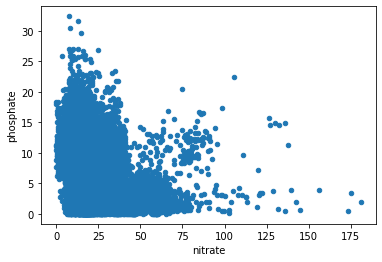

In [145]:
sub_data =  dataset[['nitrate','phosphate']].replace(0, np.nan).dropna()
sub_data.plot(x='nitrate', y='phosphate', kind='scatter')
x = np.array(sub_data['nitrate'])
y = np.array(sub_data['phosphate'])
print("Pearson R without taking log: ", sts.pearsonr(x,y)[0])
x = np.log(sub_data['nitrate'])
y = np.log(sub_data['phosphate'])
print("Pearson R after taking log: ", sts.pearsonr(x,y)[0])

In [146]:
reg_result_table = {"Increment":[],
                  "Phosphate coef": [],
                  'Nitrate coef': [],
                  'MAE testing': [],
                   'MAE training': []}

for hour_shift in range(1,24*3,1):
    reg_result_table['Increment'].append(hour_shift)
    next_chl = []
    for current_time in dataset['date']:
        time_shifted = current_time + datetime.timedelta(hours=hour_shift)
        x = dataset.loc[dataset['date']==time_shifted,'chlorophyll'].values
        if len(x) == 1:
            next_chl.append(x[0])
        else:
            next_chl.append(np.nan)
    dataset['next_chl'] = next_chl

    X_vars = ['phosphate', 'nitrate']
    y_vars = ['next_chl']
    sub_dataset = dataset[X_vars+y_vars].dropna()
    X = np.array(sub_dataset[X_vars])
    y = np.array(sub_dataset[y_vars])
    
    #20 fold cross validation:
    MAE_training = []
    MAE_testing = []
    coefs_array = [] #[Phosphate, Nitrate] at each training set
    for train_index, test_index in KFold(n_splits=20).split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #Using training set to optimize multivariate regression: 
        reg = LinearRegression().fit(X_train,y_train)
        #Predict chlorophyll-A with the training set to get MAE for training set:
        y_pred = y_pred = reg.predict(X_train)
        MAE_training.append(mean_absolute_error(y_train, y_pred))
        #Predict chlorophyll-A with the testing set to get MAE for training set:
        y_pred = reg.predict(X_test)
        MAE_testing.append(mean_absolute_error(y_test, y_pred))
        coefs_array.append(reg.coef_[0])
        
    reg_result_table['Phosphate coef'].append([x[0] for x in coefs_array])
    reg_result_table['Nitrate coef'].append([x[1] for x in coefs_array])
    reg_result_table['MAE testing'].append(np.mean(MAE_testing))
    reg_result_table['MAE training'].append(np.mean(MAE_training))

## Constrained variate regression:

In [165]:
class ConstrainedVariate():
    def __init__(self, phosphate_rate=0.2, nitrate_rate=0.01):
        self.train_phosphate = np.array([0])
        self.train_nitrate = np.array([0])
        self.train_chlorophyll = np.array([0])
        self.phosphate_rate = phosphate_rate
        self.nitrate_rate = nitrate_rate
        
    def chlorophyll_function(self, phosphate_rate, nitrate_rate):
        """
        Function that model the chlorophyll
        """
        return (phosphate_rate*self.train_phosphate 
                + nitrate_rate*self.train_nitrate)
    
    def objective_function(self, parameter_array):
        """
        Function of the difference between the 
        predicted chlorophyll (from the chlorophyll_function)
        and the actual chlorophyll
        """
        phosphate_rate, nitrate_rate = parameter_array
        predicted_chlorophyll = self.chlorophyll_function(phosphate_rate, nitrate_rate)
        difference = self.train_chlorophyll - predicted_chlorophyll
        return np.sum(difference**2)
    

    def fit(self, train_phosphate_nitrate, train_chlorophyll, method='local'):
        """
        Minimize the objective function to get the optimized 
        phosphate_rate and nitrate_rate
        """
        self.train_phosphate, self.train_nitrate = np.array(train_phosphate_nitrate).transpose()
        self.train_chlorophyll = train_chlorophyll
        
        #Optimize the model to fit the train data: 
        model = optimize.minimize(self.objective_function, 
                                  np.array([self.phosphate_rate, self.nitrate_rate]),
                                  method='SLSQP', bounds=optimize.Bounds([0,0],[np.inf, np.inf]))
        #Save the result of the model (optimized parameters) to the attribute of the class
        #so that it can be used for prediction or print out. 
        self.phosphate_rate, self.nitrate_rate = model.x 
    
        
    def predict(self, phosphate_nitrate_array):
        """
        Predict the chlorophyll from the given phosphate and nitrate 
        """
        self.train_phosphate, self.train_nitrate = np.array(phosphate_nitrate_array).transpose()
        #Use the optimized paratemeters (after fitting model with the train data) to get the chlorophyll-A:
        return self.chlorophyll_function(self.phosphate_rate, self.nitrate_rate)

In [166]:
phosphate_nitrate_array = np.array(dataset[['phosphate', 'nitrate']])
chl_array = dataset['chlorophyll']
model = ConstrainedVariate()
model.fit(phosphate_nitrate_array, chl_array)
print(model.phosphate_rate, model.nitrate_rate)

0.30869983102387294 0.10277857387760002


In [170]:
reg_result_table_1 = {"Increment":[],
                      "Phosphate coef": [],
                      'Nitrate coef': [],
                      'MAE testing': [],
                     'MAE training': []}

for hour_shift in range(1,24*3,1):
    reg_result_table_1['Increment'].append(hour_shift)
    next_chl = []
    for current_time in dataset['date']:
        time_shifted = current_time + datetime.timedelta(hours=hour_shift)
        x = dataset.loc[dataset['date']==time_shifted,'chlorophyll'].values
        if len(x) == 1:
            next_chl.append(x[0])
        else:
            next_chl.append(np.nan)
    dataset['next_chl'] = next_chl
    
    phosphate_nitrate_array = np.array(dataset[['phosphate', 'nitrate']])
    chl_array = dataset['next_chl']

    MAE_testing = []
    MAE_training = []
    coefs_array = []
    
    for train_index, test_index in KFold(n_splits=20).split(X):
        ite += 1
        X_train, X_test = phosphate_nitrate_array[train_index], phosphate_nitrate_array[test_index]
        y_train, y_test = chl_array[train_index], chl_array[test_index]

        model = ConstrainedVariate()
        model.fit(X_train, y_train)
        #Save the coefficients of phosphate, nitrate, N_over_P ratio and the errors from cross-validation:
        ##Predict y for the training set to get MAE for training set: 
        y_pred = model.predict(X_train)
        MAE_training.append(np.mean(abs(y_train-y_pred)))
        ##Predict y for testing set to get MAE for testing set: 
        y_pred = model.predict(X_test)
        MAE_testing.append(np.mean(abs(y_test-y_pred)))
        ##Parameters for the model: 
        coefs_array.append([model.phosphate_rate, model.nitrate_rate])
    
    reg_result_table_1['Phosphate coef'].append([x[0] for x in coefs_array])
    reg_result_table_1['Nitrate coef'].append([x[1] for x in coefs_array])
    reg_result_table_1['MAE testing'].append(np.mean(MAE_testing))
    reg_result_table_1['MAE training'].append(np.mean(MAE_training))

## Nutrient-algal relation after accounting the nurient regime:

Conceptual model

Optimized parameters: a1 = 1, a2 = 0.11, c1 = 20, N/P=12

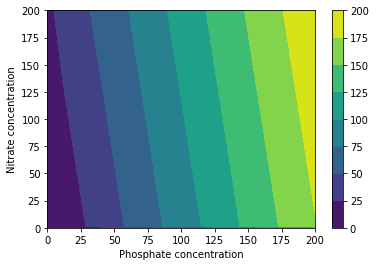

In [11]:
N_over_P_standard = 12
a1 = 1 #rate_over_P
a2 = 0.111 #rate_over_N
c1 = 10
c2 = 1/(N_over_P_standard/c1 - (a2*N_over_P_standard-a1))
nitrate_array = np.arange(1,201)
phosphate_array = np.arange(1,201)
chlorophyll_array = np.zeros((201,201))
for nitrate in nitrate_array:
    for phosphate in phosphate_array:
        #P limit:
        if nitrate/phosphate > N_over_P_standard:
            chl = a1*phosphate + nitrate/c1
        #N limit:
        if nitrate/phosphate <= N_over_P_standard: 
            chl = a2*nitrate + phosphate/c2
        chlorophyll_array[nitrate][phosphate] = chl
        
plt.figure()
#sns.heatmap(chlorophyll_array)
plt.contourf(chlorophyll_array)
#plt.ylim((1,100))
plt.ylabel("Nitrate concentration")
plt.xlabel("Phosphate concentration")
plt.colorbar()
#plt.xticks([])
#plt.yticks([])
plt.show()

As the median N/P is quite low (compared to the standard of 16), we can assume that the nutrient regime mostly belongs to the nitrogen limitted regimes, so we can try splitting the chunks of PO4 and check to coefficient of algal vs. nitrate:

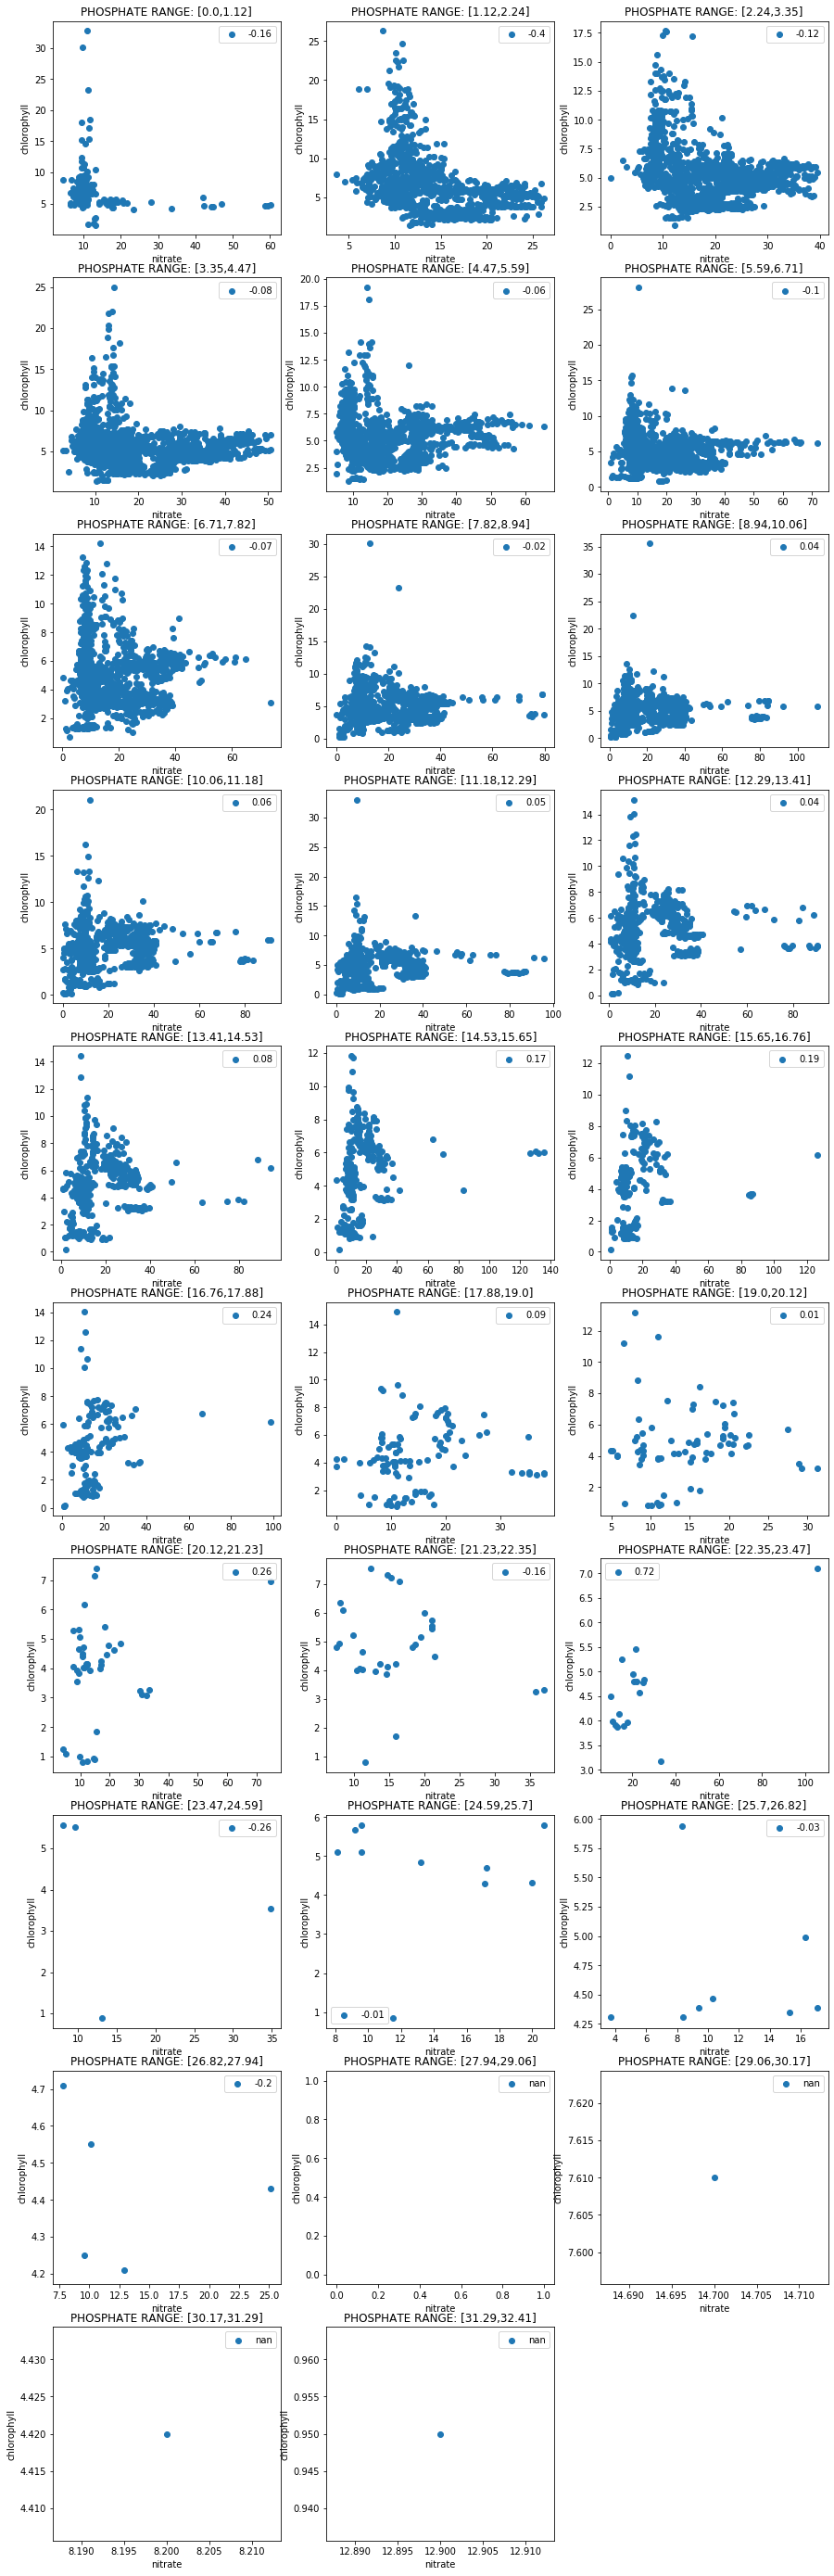

In [12]:
num_chunks = 30
nrow, ncol = 10, 3
dataset2 = dataset.loc[dataset['N/P']<= 12, ['phosphate','nitrate','chlorophyll']]
fig = plt.figure(figsize=(5*ncol,5*nrow))
i = 0
phosphate_chunks = np.linspace(np.min(dataset['phosphate']), np.max(dataset['phosphate']), num_chunks)
for upper_bound, lower_bound in zip(phosphate_chunks[1:], phosphate_chunks[:-1]):
    i += 1
    ax = fig.add_subplot(nrow, ncol, i)
    select_rows = (dataset2['phosphate']>=lower_bound)&(dataset2['phosphate']<upper_bound)
    sub_data = dataset2.loc[select_rows,['nitrate','chlorophyll']]
    ax.scatter(sub_data['nitrate'], sub_data['chlorophyll'], 
               label=round(np.array(sub_data.corr())[0,1],2))
    ax.set_xlabel('nitrate')
    ax.set_ylabel('chlorophyll')
    ax.legend()
    ax.set_title(f"PHOSPHATE RANGE: [{round(lower_bound,2)},{round(upper_bound,2)}]")

P limit
N limit


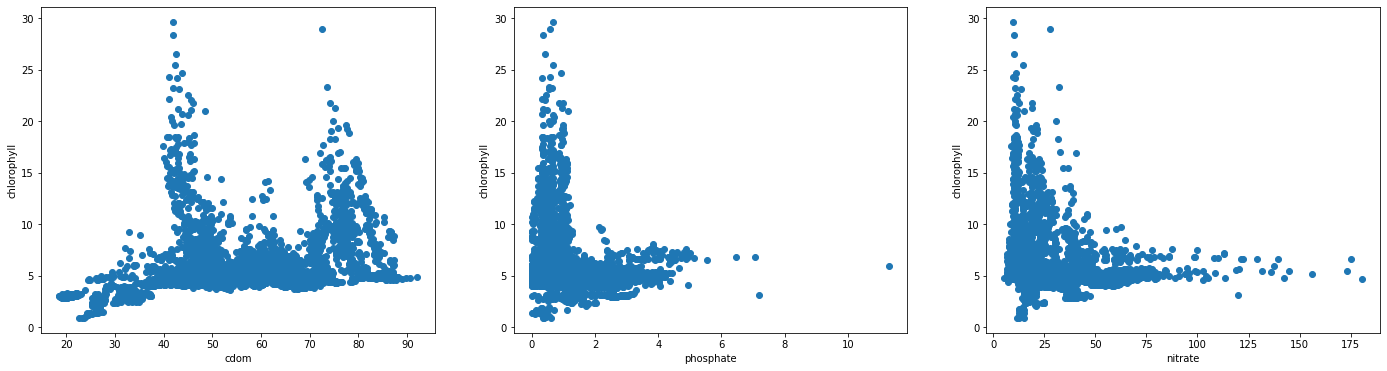

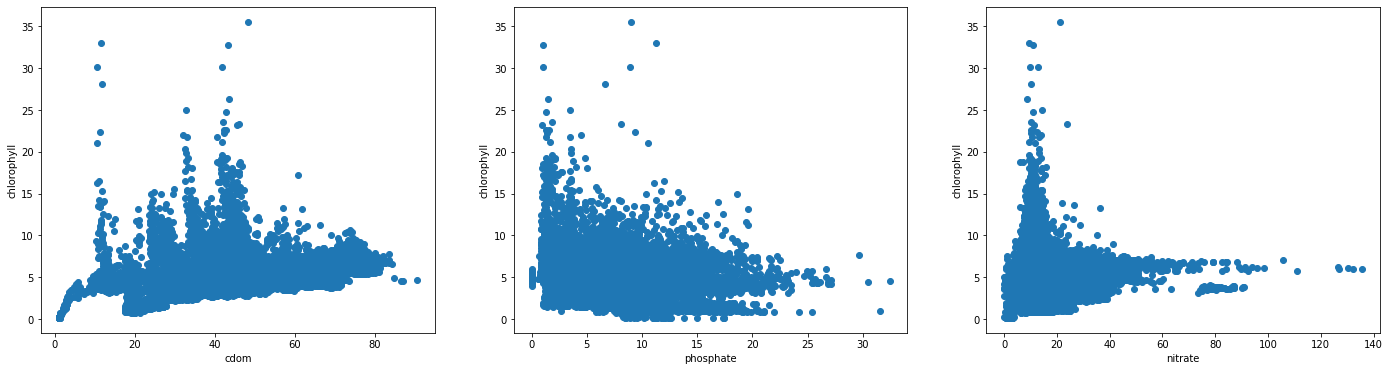

In [13]:
standard = 12
for title in ["P limit", 'N limit']:
    if title == 'P limit':
        sub_data = dataset.loc[dataset['N/P']>=standard,:]
    if title == 'N limit':
        sub_data = dataset.loc[dataset['N/P']<standard,:]
        
    nrow, ncol = 1, 3
    fig = plt.figure(figsize=(8*ncol,6*nrow))
    print(title)
    i = 0
    for nutrient in ['cdom', 'phosphate', 'nitrate']:
        i +=1
        ax = fig.add_subplot(nrow, ncol, i)
        ax.scatter(sub_data[nutrient], sub_data['chlorophyll'])
        ax.set_xlabel(nutrient)
        ax.set_ylabel('chlorophyll')

### Nutrient model: 
Training material: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html

In [226]:
class NutrientLimitModel():
    def __init__(self, phosphate_rate=0.2, nitrate_rate=0.01, N_over_P_standard=20):
        self.train_phosphate = np.array([0])
        self.train_nitrate = np.array([0])
        self.train_chlorophyll = np.array([0])
        self.phosphate_rate = phosphate_rate
        self.nitrate_rate = nitrate_rate
        self.N_over_P_standard = N_over_P_standard
        
    def conceptual_model(self):
        nitrate_array = np.linspace(0.1,100,50)
        phosphate_array = np.linspace(0.1,40,50)
        chlorophyll_array = np.zeros((50,50))
        for y, nitrate in enumerate(nitrate_array):
            for x, phosphate in enumerate(phosphate_array):
                #P limit:
                if nitrate/phosphate > self.N_over_P_standard:
                    chl = self.phosphate_rate*phosphate
                #N limit:
                if nitrate/phosphate <= N_over_P_standard: 
                    chl = self.nitrate_rate*nitrate
                chlorophyll_array[y][x] = chl
                
        plt.figure(figsize=(8,6))
        plt.contourf(phosphate_array, nitrate_array, chlorophyll_array)
        plt.plot(phosphate_array, phosphate_array*self.N_over_P_standard, 
                 linewidth=3, linestyle='--', color='red')
        plt.ylim(min(nitrate_array), max(nitrate_array))
        plt.ylabel("Nitrate concentration (uM/L)")
        plt.xlabel("Phosphate concentration (uM/L)")
        plt.colorbar()
        plt.show()
        
    def chlorophyll_function(self, phosphate_rate, nitrate_rate, N_over_P_standard):
        """
        Function that model the chlorophyll
        """
        N_over_P_calculate = self.train_nitrate/self.train_phosphate
        P_limit_indication = N_over_P_calculate >= N_over_P_standard
        N_limit_indication = N_over_P_calculate < N_over_P_standard
        return (P_limit_indication*phosphate_rate*self.train_phosphate 
                + N_limit_indication*nitrate_rate*self.train_nitrate)
    
    def objective_function(self, parameter_array):
        """
        Function of the difference between the 
        predicted chlorophyll (from the chlorophyll_function)
        and the actual chlorophyll
        """
        phosphate_rate, nitrate_rate, N_over_P_standard = parameter_array
        predicted_chlorophyll = self.chlorophyll_function(phosphate_rate, nitrate_rate, N_over_P_standard)
        difference = self.train_chlorophyll - predicted_chlorophyll
        return np.sum(difference**2)
    
    def constraint_1(self):
        """
        Constraint that all the components of the parameter array are positive. 
        """
        lower_bound = [0,0,0] #Greater than 0
        upper_bound = [np.inf, np.inf, np.inf]
        T_matrix = [[1,0,0],[0,1,0],[0,0,1]] #Transfer the parameter array to corresponding components
        return optimize.LinearConstraint(T_matrix, lower_bound, upper_bound)
    
    def func_of_constraint_2(self, parameter_array):
        """
        rate P - rate N * N_over_P_standard
        """
        phosphate_rate, nitrate_rate, N_over_P_standard = parameter_array
        return phosphate_rate - nitrate_rate*N_over_P_standard
        
    def constraint_2(self):
        """
        Constraint: rate P / rate N = standard N over P, 
        or rate P - rate N * standard N over P = 0. 
        """
        func = lambda parameter_array: parameter_array[0] - parameter_array[1]*parameter_array[2]
        return optimize.NonlinearConstraint(func, 0, 0)

    def fit(self, train_phosphate_nitrate, train_chlorophyll):
        """
        Minimize the objective function to get the optimized 
        phosphate_rate and nitrate_rate
        """
        self.train_phosphate, self.train_nitrate = np.array(train_phosphate_nitrate).transpose()
        self.train_chlorophyll = train_chlorophyll
        
        #Optimize the model to fit the train data: 
        model = optimize.minimize(self.objective_function, 
                                  np.array([self.phosphate_rate, self.nitrate_rate, self.N_over_P_standard]),
                                  method='SLSQP',
                                  constraints=[self.constraint_1(), self.constraint_2()])
            
        #Save the result of the model (optimized parameters) to the attribute of the class
        #so that it can be used for prediction or print out. 
        self.phosphate_rate, self.nitrate_rate, self.N_over_P_standard = model.x 
        
    def predict(self, phosphate_nitrate_array):
        """
        Predict the chlorophyll from the given phosphate and nitrate 
        """
        self.train_phosphate, self.train_nitrate = np.array(phosphate_nitrate_array).transpose()
        #Use the optimized paratemeters (after fitting model with the train data) to get the chlorophyll-A:
        return self.chlorophyll_function(self.phosphate_rate, self.nitrate_rate, 
                                        self.N_over_P_standard)

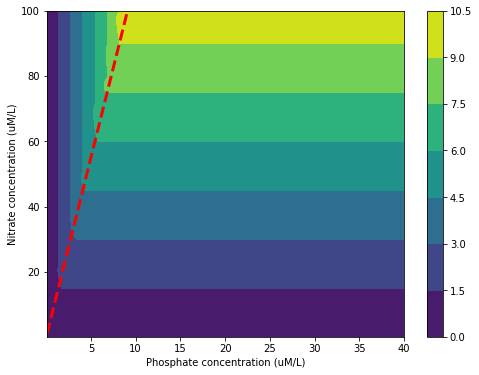

In [229]:
model = NutrientLimitModel(1.1,0.1,11)
model.conceptual_model()

In [104]:
phosphate_nitrate_array = np.array(dataset[['phosphate', 'nitrate']])
chl_array = dataset['chlorophyll']

MAE_array = []
coefs_array = []
for train_index, test_index in KFold(n_splits=40).split(X):
    X_train, X_test = phosphate_nitrate_array[train_index], phosphate_nitrate_array[test_index]
    y_train, y_test = chl_array[train_index], chl_array[test_index]
    
    model = NutrientLimitModel()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    #Print result to double check:
    if False:
        print(model.phosphate_rate, model.nitrate_rate,model.N_over_P_standard)
        print(np.mean(abs(y_pred-y_test)))
    #Save the coefficients of phosphate, nitrate, N_over_P ratio and the errors from cross-validation: 
    MAE_array.append(np.mean(abs(y_pred-y_test)))
    coefs_array.append([model.phosphate_rate, model.nitrate_rate,model.N_over_P_standard])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater_equal
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


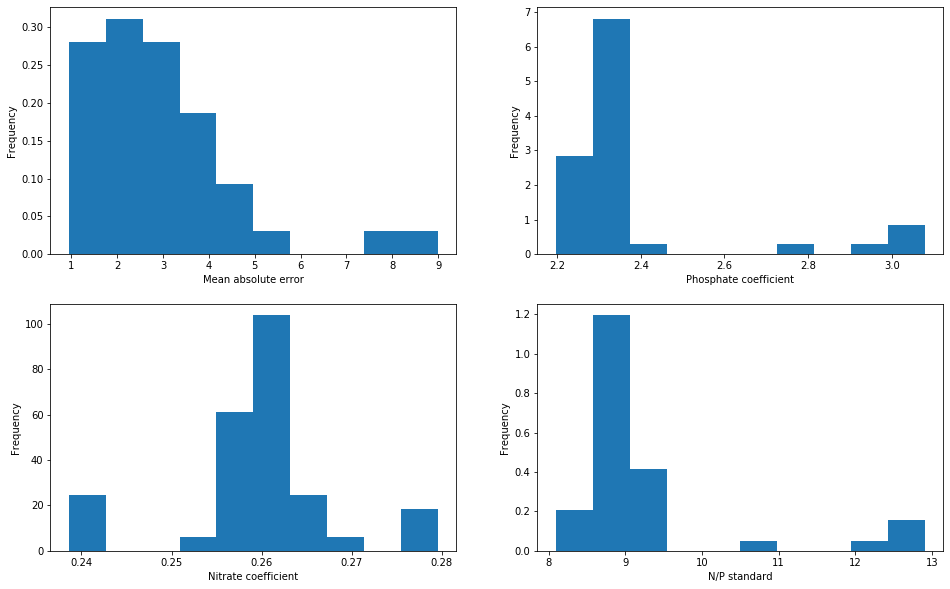

In [106]:
ncols = 2
nrows = 2
plt.figure(figsize=(ncols*8, nrows*5))

plt.subplot(nrows, ncols, 1)
plt.hist(MAE_array, density=True)
plt.ylabel("Frequency")
plt.xlabel("Mean absolute error")

plt.subplot(nrows, ncols, 2)
plt.hist([x[0] for x in coefs_array], density=True)
plt.ylabel("Frequency")
plt.xlabel('Phosphate coefficient')

plt.subplot(nrows, ncols, 3)
plt.hist([x[1] for x in coefs_array], density=True)
plt.ylabel("Frequency")
plt.xlabel('Nitrate coefficient')

plt.subplot(nrows, ncols, 4)
plt.hist([x[2] for x in coefs_array], density=True)
plt.ylabel("Frequency")
plt.xlabel('N/P standard')

plt.show()

In [149]:
reg_result_table_2 = {"Increment":[],
                      "Phosphate coef": [],
                      'Nitrate coef': [],
                      'N/P standard': [],
                      'MAE testing': [],
                     'MAE training': []}

for hour_shift in range(1,24*3,1):
    reg_result_table_2['Increment'].append(hour_shift)
    next_chl = []
    for current_time in dataset['date']:
        time_shifted = current_time + datetime.timedelta(hours=hour_shift)
        x = dataset.loc[dataset['date']==time_shifted,'chlorophyll'].values
        if len(x) == 1:
            next_chl.append(x[0])
        else:
            next_chl.append(np.nan)
    dataset['next_chl'] = next_chl
    
    phosphate_nitrate_array = np.array(dataset[['phosphate', 'nitrate']])
    chl_array = dataset['next_chl']

    MAE_testing = []
    MAE_training = []
    coefs_array = []
    
    for train_index, test_index in KFold(n_splits=20).split(X):
        X_train, X_test = phosphate_nitrate_array[train_index], phosphate_nitrate_array[test_index]
        y_train, y_test = chl_array[train_index], chl_array[test_index]

        model = NutrientLimitModel()
        model.fit(X_train, y_train)
        #Save the coefficients of phosphate, nitrate, N_over_P ratio and the errors from cross-validation:
        ##Predict y for the training set to get MAE for training set: 
        y_pred = model.predict(X_train)
        MAE_training.append(np.mean(abs(y_train-y_pred)))
        ##Predict y for testing set to get MAE for testing set: 
        y_pred = model.predict(X_test)
        MAE_testing.append(np.mean(abs(y_test-y_pred)))
        ##Parameters for the model: 
        coefs_array.append([model.phosphate_rate, model.nitrate_rate,model.N_over_P_standard])
    
    reg_result_table_2['Phosphate coef'].append([x[0] for x in coefs_array])
    reg_result_table_2['Nitrate coef'].append([x[1] for x in coefs_array])
    reg_result_table_2['N/P standard'].append([x[2] for x in coefs_array])
    reg_result_table_2['MAE testing'].append(np.mean(MAE_testing))
    reg_result_table_2['MAE training'].append(np.mean(MAE_training))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater_equal
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


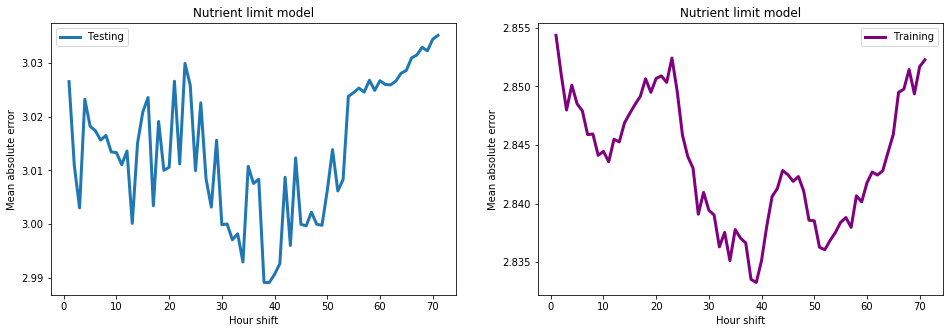

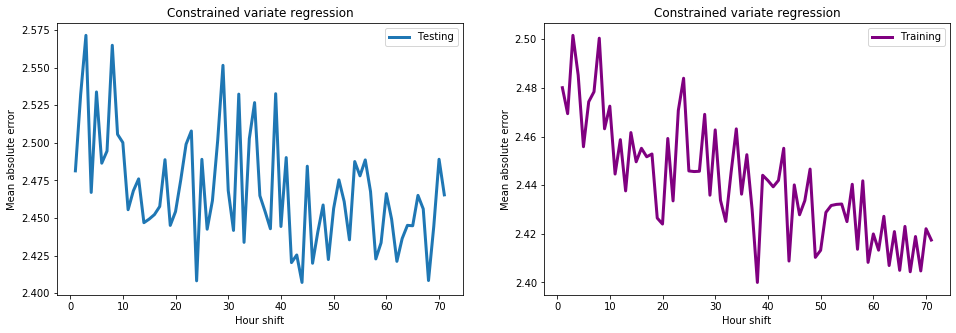

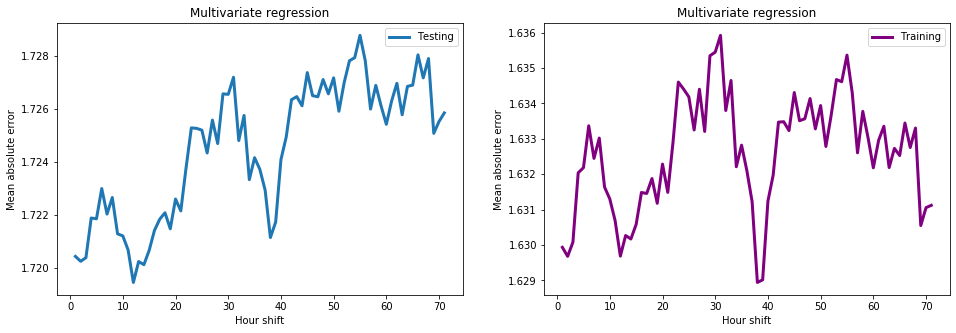

In [175]:
ncols = 2
nrows = 1
model_name_list = ["Nutrient limit model","Constrained variate regression", "Multivariate regression"]
reg_table_list = [reg_result_table_2, reg_result_table_1, reg_result_table]

for table, model_name in zip(reg_table_list, model_name_list):
    plt.figure(figsize=(ncols*8, nrows*5))
    plt.subplot(nrows, ncols, 1)
    plt.title(model_name)
    plt.plot(table['Increment'], table['MAE testing'], 
             label='Testing', linewidth=3)
    plt.xlabel("Hour shift")
    plt.ylabel("Mean absolute error")
    plt.legend()

    plt.subplot(nrows, ncols, 2)
    plt.title(model_name)
    plt.plot(table['Increment'], table['MAE training'], 
             label='Training', linewidth=3, color='purple')
    plt.xlabel("Hour shift")
    plt.ylabel("Mean absolute error")
    plt.legend()
    plt.show()

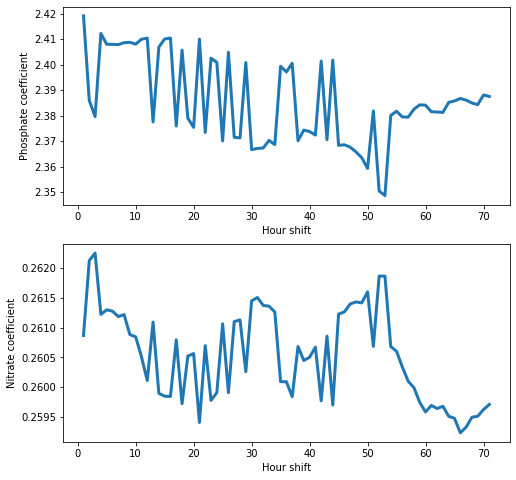

In [181]:
#The coefficient of phosphate and nitrate in multivariate regressions: 
nrow, ncol = 2, 1
fig = plt.figure(figsize=(8*ncol,4*nrow))
i = 0
for coef in ['Phosphate coef', 'Nitrate coef']:
    i += 1
    ax = fig.add_subplot(nrow, ncol, i)
    sub_data = reg_result_table_2[coef] 
    x_array = reg_result_table['Increment']
    mean_y = np.array([np.mean(x) for x in sub_data])
    y_err = 1.96*np.array([np.std(x) for x in sub_data])
    ax.plot(x_array, mean_y, linewidth=3)
    #ax.fill_between(x_array, (mean_y-y_err), (mean_y+y_err), color='b', alpha=.1)
    ax.set_xlabel('Hour shift')
    ax.set_ylabel(coef+"ficient")

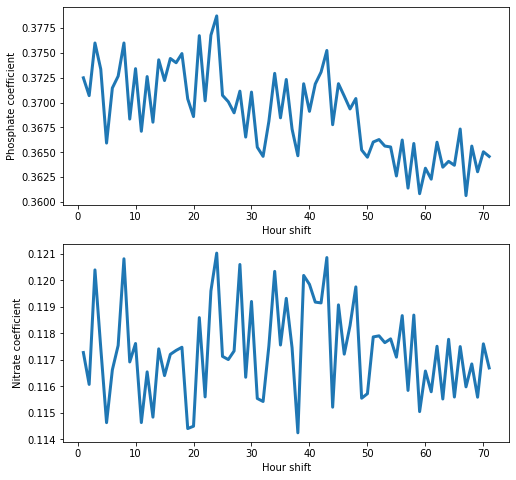

In [182]:
#The coefficient of phosphate and nitrate in multivariate regressions: 
nrow, ncol = 2, 1
fig = plt.figure(figsize=(8*ncol,4*nrow))
i = 0
for coef in ['Phosphate coef', 'Nitrate coef']:
    i += 1
    ax = fig.add_subplot(nrow, ncol, i)
    sub_data = reg_result_table_1[coef] 
    x_array = reg_result_table['Increment']
    mean_y = np.array([np.mean(x) for x in sub_data])
    y_err = 1.96*np.array([np.std(x) for x in sub_data])
    ax.plot(x_array, mean_y, linewidth=3)
    #ax.fill_between(x_array, (mean_y-y_err), (mean_y+y_err), color='b', alpha=.1)
    ax.set_xlabel('Hour shift')
    ax.set_ylabel(coef+"ficient")

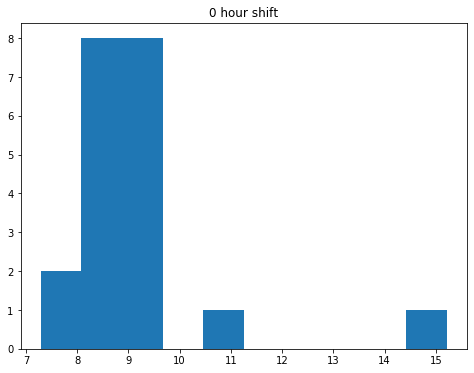

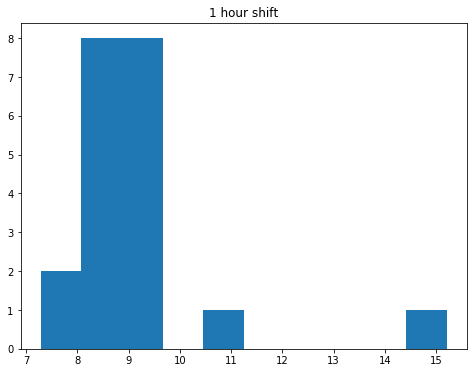

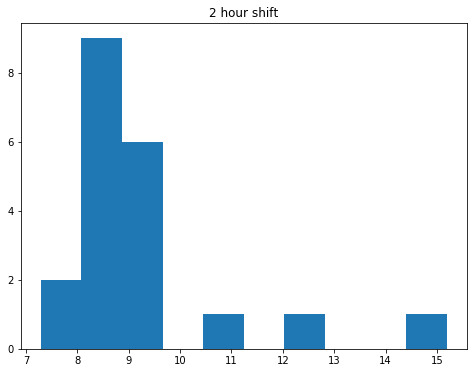

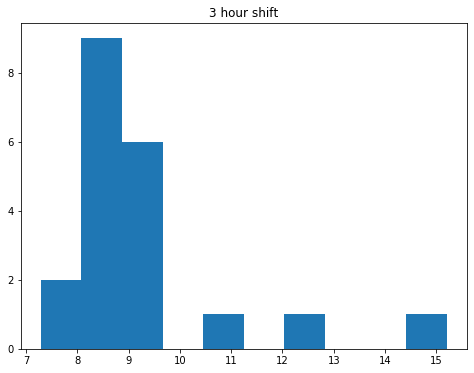

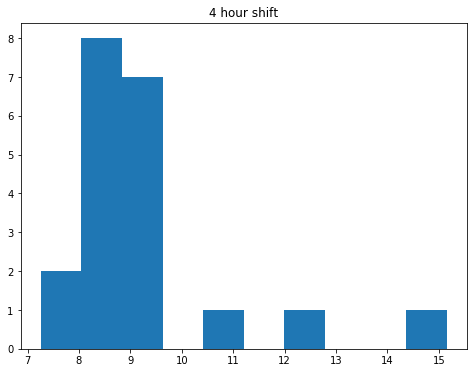

In [126]:
for i in range(0,5):
    plt.figure(figsize=(8,6))
    plt.hist(reg_result_table_2['N/P standard'][i])
    plt.title(f"{i} hour shift")
    plt.show()

In [128]:
for i in range(0,20):
    print(i)
    print(np.mean(reg_result_table_2['N/P standard'][i]))

0
9.133584540724318
1
9.116182764723082
2
9.268768825673998
3
9.267912997101163
4
9.260886218249523
5
9.269576517787671
6
9.267705786344537
7
9.26764405624554
8
9.278982595365283
9
9.277221251055028
10
9.301891071514321
11
9.146464374058874
12
9.144616262579381
13
9.31571972103378
14
9.312488723333558
15
9.307133592125568
16
9.148031790243484
17
9.144256713936223
18
9.325039301584718
19
9.315953053084382


## N/P statistics:

95% interval of N/P distribution:  [  0.54696023 107.91150671]
Median of N/P distribution:  4.594594594594595


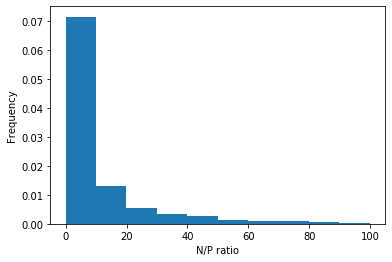

In [137]:
df = dataset['N/P']
df = df[df.replace([np.inf, -np.inf], np.nan).notnull()]
print("95% interval of N/P distribution: ", np.percentile(df, [2.5,97.5]))
print("Median of N/P distribution: ", np.percentile(df, 50))
df = df[df<100]
plt.hist(df, density=True)
plt.xlabel("N/P ratio")
plt.ylabel("Frequency")
plt.show()

In [263]:
class NutrientLimitModel2():
    def __init__(self, phosphate_rate=0.2, nitrate_rate=0.01, N_over_P_standard=20):
        self.train_phosphate = np.array([0])
        self.train_nitrate = np.array([0])
        self.train_chlorophyll = np.array([0])
        self.phosphate_rate = phosphate_rate
        self.nitrate_rate = nitrate_rate
        self.N_over_P_standard = N_over_P_standard
        
    def conceptual_model(self):
        nitrate_array = np.linspace(0.1,100,50)
        phosphate_array = np.linspace(0.1,40,50)
        chlorophyll_array = np.zeros((50,50))
        for y, nitrate in enumerate(nitrate_array):
            for x, phosphate in enumerate(phosphate_array):
                #P limit:
                if nitrate/phosphate > self.N_over_P_standard:
                    chl = self.phosphate_rate*phosphate
                #N limit:
                if nitrate/phosphate <= N_over_P_standard: 
                    chl = self.nitrate_rate*nitrate
                chlorophyll_array[y][x] = chl
                
        plt.figure(figsize=(8,6))
        plt.contourf(phosphate_array, nitrate_array, chlorophyll_array)
        plt.plot(phosphate_array, phosphate_array*self.N_over_P_standard, 
                 linewidth=3, linestyle='--', color='red')
        plt.ylim(min(nitrate_array), max(nitrate_array))
        plt.ylabel("Nitrate concentration (uM/L)")
        plt.xlabel("Phosphate concentration (uM/L)")
        plt.colorbar()
        plt.show()
        
    def chlorophyll_function(self, phosphate_rate, nitrate_rate):
        """
        Function that model the chlorophyll
        """
        N_over_P_calculate = self.train_nitrate/self.train_phosphate
        P_limit_indication = N_over_P_calculate >= self.N_over_P_standard
        N_limit_indication = N_over_P_calculate < self.N_over_P_standard
        return (P_limit_indication*phosphate_rate*self.train_phosphate 
                + N_limit_indication*nitrate_rate*self.train_nitrate)
    
    def objective_function(self, parameter_array):
        """
        Function of the difference between the 
        predicted chlorophyll (from the chlorophyll_function)
        and the actual chlorophyll
        """
        phosphate_rate, nitrate_rate = parameter_array
        predicted_chlorophyll = self.chlorophyll_function(phosphate_rate, nitrate_rate)
        difference = self.train_chlorophyll - predicted_chlorophyll
        return np.sum(difference**2)
    
    def constraint_1(self):
        """
        Constraint that all the components of the parameter array are positive. 
        """
        lower_bound = [0,0] #Greater than 0
        upper_bound = [np.inf, np.inf]
        T_matrix = [[1,0],[0,1]] #Transfer the parameter array to corresponding components
        return optimize.LinearConstraint(T_matrix, lower_bound, upper_bound)
        
    def constraint_2(self):
        """
        Constraint: rate P / rate N = standard N over P, 
        or rate P - rate N * standard N over P = 0. 
        """
        func = lambda parameter_array: parameter_array[0] - parameter_array[1]*self.N_over_P_standard
        return optimize.NonlinearConstraint(func, 0, 0)

    def fit(self, train_phosphate_nitrate, train_chlorophyll):
        """
        Minimize the objective function to get the optimized 
        phosphate_rate and nitrate_rate
        """
        self.train_phosphate, self.train_nitrate = np.array(train_phosphate_nitrate).transpose()
        self.train_chlorophyll = train_chlorophyll
        
        #Optimize the model to fit the train data: 
        model = optimize.minimize(self.objective_function, 
                                  np.array([self.phosphate_rate, self.nitrate_rate]),
                                  method='SLSQP',
                                  constraints=[self.constraint_1(), self.constraint_2()])

        #Save the result of the model (optimized parameters) to the attribute of the class
        #so that it can be used for prediction or print out. 
        self.phosphate_rate, self.nitrate_rate = model.x 
        
    def predict(self, phosphate_nitrate_array):
        """
        Predict the chlorophyll from the given phosphate and nitrate 
        """
        self.train_phosphate, self.train_nitrate = np.array(phosphate_nitrate_array).transpose()
        #Use the optimized paratemeters (after fitting model with the train data) to get the chlorophyll-A:
        return self.chlorophyll_function(self.phosphate_rate, self.nitrate_rate)

In [260]:
model = NutrientLimitModel2(N_over_P_standard=10)
X = dataset[['phosphate', 'nitrate']]
y = dataset['chlorophyll']
model.fit(X,y)
print(model.phosphate_rate, model.nitrate_rate)
model.predict(X)

1.9995583047361345 0.19995583047361343


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater_equal
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


array([ 3.35925795,  2.67940813,  2.45945671, ..., 14.99668729,
       14.83672262, 15.23663428])

In [262]:
X = np.array(dataset[['phosphate', 'nitrate']])
y = np.array(dataset['chlorophyll'])

#20 fold cross validation:
MAE_training = []
MAE_testing = [] 

N_over_P_standard_array = np.linspace(1,20,2)

for train_index, test_index in KFold(n_splits=10).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    temp_array_training = []
    temp_array_testing = []
    for N_over_P_standard in N_over_P_standard_array:
        model = NutrientLimitModel2(N_over_P_standard=10)
        model.fit(X_train, y_train)
        print(model.phosphate_rate, model.nitrate_rate)
        y_pred = model.predict(X_train)
        print(X_train)
        print(y_pred)
        temp_array_training.append(np.mean(abs(y_train-y_pred)))
        #print(np.mean(abs(y_train-y_pred)))
        ##Predict y for testing set to get MAE for testing set: 
        y_pred = model.predict(X_test)
        print(X_test)
        print(y_pred)
        temp_array_testing.append(np.mean(abs(y_test-y_pred)))
        #print(np.mean(abs(y_test-y_pred)))
        
    MAE_training.append(temp_array_training)
    MAE_testing.append(temp_array_testing)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater_equal
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


nan nan
[[ 9.56  8.9 ]
 [ 9.22  8.4 ]
 [10.01  8.7 ]
 ...
 [ 8.4  75.  ]
 [ 8.3  74.2 ]
 [ 8.38 76.2 ]]
[nan nan nan ... nan nan nan]
[[ 2.25 16.8 ]
 [ 1.97 13.4 ]
 [ 1.87 12.3 ]
 ...
 [ 9.01  9.3 ]
 [ 8.07  8.4 ]
 [ 9.36  9.5 ]]
[nan nan nan ... nan nan nan]
nan nan
[[ 9.56  8.9 ]
 [ 9.22  8.4 ]
 [10.01  8.7 ]
 ...
 [ 8.4  75.  ]
 [ 8.3  74.2 ]
 [ 8.38 76.2 ]]
[nan nan nan ... nan nan nan]
[[ 2.25 16.8 ]
 [ 1.97 13.4 ]
 [ 1.87 12.3 ]
 ...
 [ 9.01  9.3 ]
 [ 8.07  8.4 ]
 [ 9.36  9.5 ]]
[nan nan nan ... nan nan nan]
nan nan
[[ 2.25 16.8 ]
 [ 1.97 13.4 ]
 [ 1.87 12.3 ]
 ...
 [ 8.4  75.  ]
 [ 8.3  74.2 ]
 [ 8.38 76.2 ]]
[nan nan nan ... nan nan nan]
[[ 9.56  8.9 ]
 [ 9.22  8.4 ]
 [10.01  8.7 ]
 ...
 [14.28 49.7 ]
 [11.31 35.  ]
 [12.42 31.7 ]]
[nan nan nan ... nan nan nan]
nan nan
[[ 2.25 16.8 ]
 [ 1.97 13.4 ]
 [ 1.87 12.3 ]
 ...
 [ 8.4  75.  ]
 [ 8.3  74.2 ]
 [ 8.38 76.2 ]]
[nan nan nan ... nan nan nan]
[[ 9.56  8.9 ]
 [ 9.22  8.4 ]
 [10.01  8.7 ]
 ...
 [14.28 49.7 ]
 [11.31 35.  ]
 [12.4

In [257]:
X_test

array([[ 3.56, 51.6 ],
       [ 3.2 , 46.8 ],
       [ 3.24, 49.9 ],
       ...,
       [ 8.4 , 75.  ],
       [ 8.3 , 74.2 ],
       [ 8.38, 76.2 ]])

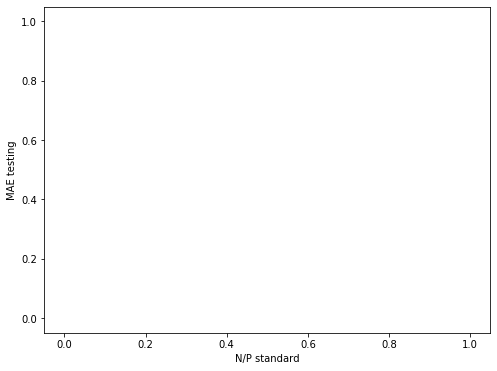

In [252]:
plt.figure(figsize=(8,6))
plt.xlabel("N/P standard")
plt.ylabel("MAE testing")
plt.plot(N_over_P_standard_array,
         np.mean(MAE_training,axis=0))
plt.show()